# Overview

In [ ]:
!pip install seaborn
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install plotly
!pip install imbalanced-learn

In [ ]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc

In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
data = pd.read_parquet("preprocessed_data_A.parquet")
data["Victim IP Number"] = data["Victim IP"].str.extract(r"IP_(\d+)").astype(int)
data["Type_Original"] = data["Type"]
data = pd.get_dummies(data, columns=['Type'])
data = data.rename(columns={"Type_Original": "Type"})
data.info()

FileNotFoundError: [Errno 2] No such file or directory: 'preprocessed_data_A.parquet'

In [ ]:
df = data.rename(columns={
    "Victim IP Number": "victim_ip",
    "Port number": "port_number",
    "Packet speed": "packet_speed",
    "Data speed": "data_speed",
    "Avg packet len": "packet_len",
    "Source IP count": "source_ip",
    "Start_time_hour_sin": "start_hour",
    "Start_time_weekday_sin": "start_weekday",
    "Start_time_dayofyear_sin": "start_dayofyear",
    "End_time_hour_sin": "end_hour",
    "End_time_weekday_sin": "end_weekday",
    "End_time_dayofyear_sin": "end_dayofyear",
    "Type_DDoS attack": "type_ddos",
    "Type_Normal traffic": "type_normal",
    "Type_Suspicious traffic": "type_sus"
})[
    ["victim_ip", "port_number", "packet_speed", "data_speed", "packet_len", "source_ip",
     "start_hour", "start_weekday", "start_dayofyear", "end_hour", "end_weekday", "end_dayofyear",
     "type_ddos", "type_normal", "type_sus"]
]

df["type"] = df[["type_ddos", "type_sus", "type_normal"]].idxmax(axis=1)
df["type"] = df["type"].map({"type_ddos": "ddos", "type_sus": "sus", "type_normal": "normal"})
df = df.drop(columns=["type_ddos", "type_sus", "type_normal"])

df.head()

,victim_ip,port_number,packet_speed,data_speed,packet_len,source_ip,start_hour,start_weekday,start_dayofyear,end_hour,end_weekday,end_dayofyear,type
0,1,4500,55600.0,73.0,1383.0,6.0,-1.0,0.0,-0.601624,-1.0,0.0,-0.601624,normal
1,2,4500,63500.0,90.0,1506.0,1.0,-1.0,0.0,-0.601624,-1.0,0.0,-0.601624,normal
2,3,1200,59700.0,79.0,1399.0,1.0,-1.0,0.0,-0.601624,-1.0,0.0,-0.601624,normal
3,3,1200,65700.0,86.0,1399.0,1.0,-1.0,0.0,-0.601624,-1.0,0.0,-0.601624,normal
4,2,4500,59500.0,85.0,1486.0,1.0,-1.0,0.0,-0.601624,-1.0,0.0,-0.601624,normal


# Common

In [ ]:
# Current feature importance analysis
def feature_importance_analysis(df):
  df_temp = df.copy()

  X = df_temp.drop(columns=["type"])
  y = df_temp["type"]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

  model = RandomForestClassifier(n_estimators=100, random_state=42)
  model.fit(X_train, y_train)

  feature_importances = model.feature_importances_

  importance_df = pd.DataFrame({"Feature": X.columns, "Importance": feature_importances})
  importance_df = importance_df.sort_values(by="Importance", ascending=False)

  plt.figure(figsize=(12, 6))
  plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
  plt.xlabel("Feature Importance Score")
  plt.ylabel("Features")
  plt.title("Feature Importance Analysis")
  plt.gca().invert_yaxis()
  plt.show()

In [ ]:
# Compare PR AUC for original and multiple resampled datasets.
def compare_pr_auc(original_df, resampled_dfs, percentages=[25, 50, 100]):
    df_original = original_df.copy()

    X_original = df_original.drop(columns=["type"])
    y_original = df_original["type"].map({"ddos": 1, "sus": 2, "normal": 0})

    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
        X_original, y_original, test_size=0.2, random_state=42
    )

    scaler = StandardScaler()
    X_train_orig = scaler.fit_transform(X_train_orig)
    X_test_orig = scaler.transform(X_test_orig)

    model = LogisticRegression(random_state=42)
    model.fit(X_train_orig, y_train_orig)
    y_probs_orig = model.predict_proba(X_test_orig)[:, 1]

    precision_orig, recall_orig, _ = precision_recall_curve(y_test_orig, y_probs_orig, pos_label=1)
    pr_auc_orig = auc(recall_orig, precision_orig)

    print(f"PR AUC for the original dataset: {pr_auc_orig:.4f}")

    plt.figure(figsize=(10, 6))
    plt.plot(recall_orig, precision_orig, label=f"Original PR AUC = {pr_auc_orig:.4f}", color='black')

    colors = ["blue", "green", "red"]
    for idx, perc in enumerate(percentages):
        if perc not in resampled_dfs:
            print(f"Skipping {perc}% resampled dataset (not provided)")
            continue

        df_resampled = resampled_dfs[perc]
        X_resampled = df_resampled.drop(columns=["type"])
        y_resampled = df_resampled["type"].map({"ddos": 1, "sus": 2, "normal": 0})

        X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(
            X_resampled, y_resampled, test_size=0.2, random_state=42
        )

        X_train_res = scaler.fit_transform(X_train_res)
        X_test_res = scaler.transform(X_test_res)

        model.fit(X_train_res, y_train_res)
        y_probs_res = model.predict_proba(X_test_res)[:, 1]

        precision_res, recall_res, _ = precision_recall_curve(y_test_res, y_probs_res, pos_label=1)
        pr_auc_res = auc(recall_res, precision_res)

        print(f"PR AUC for {perc}% resampled dataset: {pr_auc_res:.4f}")

        plt.plot(recall_res, precision_res, label=f"{perc}% Resampled PR AUC = {pr_auc_res:.4f}", color=colors[idx])

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve Comparison")
    plt.legend(loc="best")
    plt.show()

In [ ]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, KMeansSMOTE

def resample_data(sampling_method, percentage):
    df_temp = df.copy()

    X = df_temp.drop(columns=["type"])
    y = df_temp["type"]

    target_samples = int(len(y[y == "normal"]) * percentage)

    sampler_methods = {
        "SMOTE": SMOTE(sampling_strategy={"ddos": target_samples}),
        "ADASYN": ADASYN(sampling_strategy={"ddos": target_samples}),
        "ROS": RandomOverSampler(sampling_strategy={"ddos": target_samples}),
        "BorderlineSMOTE": BorderlineSMOTE(sampling_strategy={"ddos": target_samples}),
        "KMeansSMOTE": KMeansSMOTE(sampling_strategy={"ddos": target_samples})
    }

    if sampling_method not in sampler_methods:
        raise ValueError(f"Invalid sampling method. Choose from: {list(sampler_methods.keys())}")

    sampler = sampler_methods[sampling_method]

    X_resampled, y_resampled = sampler.fit_resample(X, y)
    df_resampled = pd.concat([X_resampled, y_resampled], axis=1)

    return df_resampled

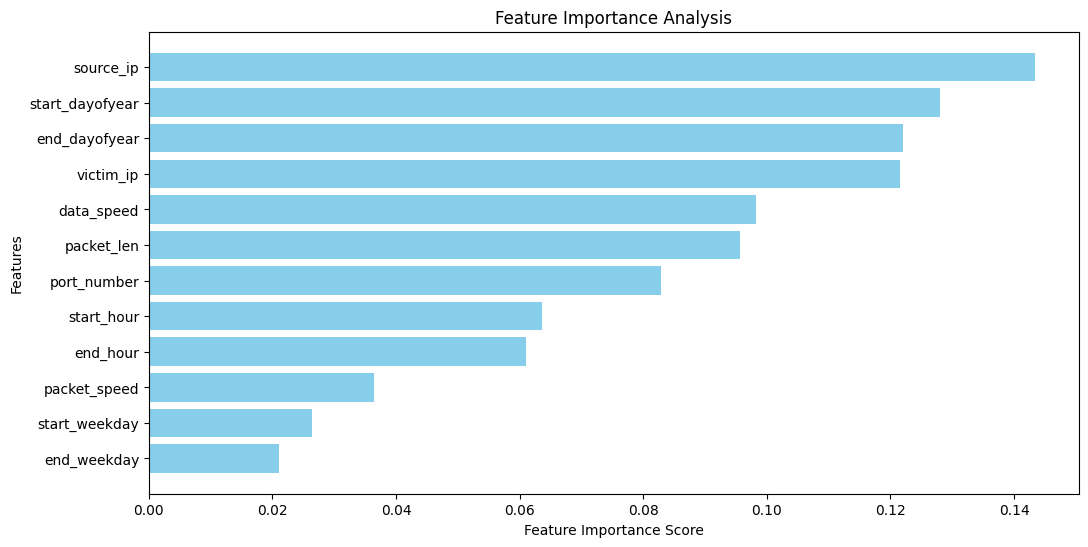

In [ ]:
feature_importance_analysis(df)

# RandomOverSampler

PR AUC for the original dataset: 0.8233
PR AUC for 25% resampled dataset: 0.8621
PR AUC for 50% resampled dataset: 0.9178
PR AUC for 100% resampled dataset: 0.9529


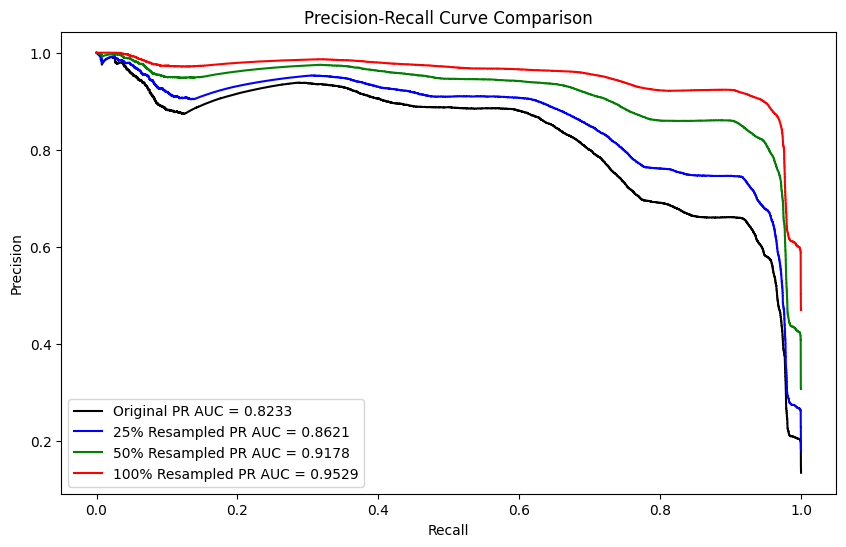

In [ ]:
compare_pr_auc(original_df=df, resampled_dfs={
    25: resample_data("ROS", 0.25),
    50: resample_data("ROS", 0.5),
    100: resample_data("ROS", 1)
})

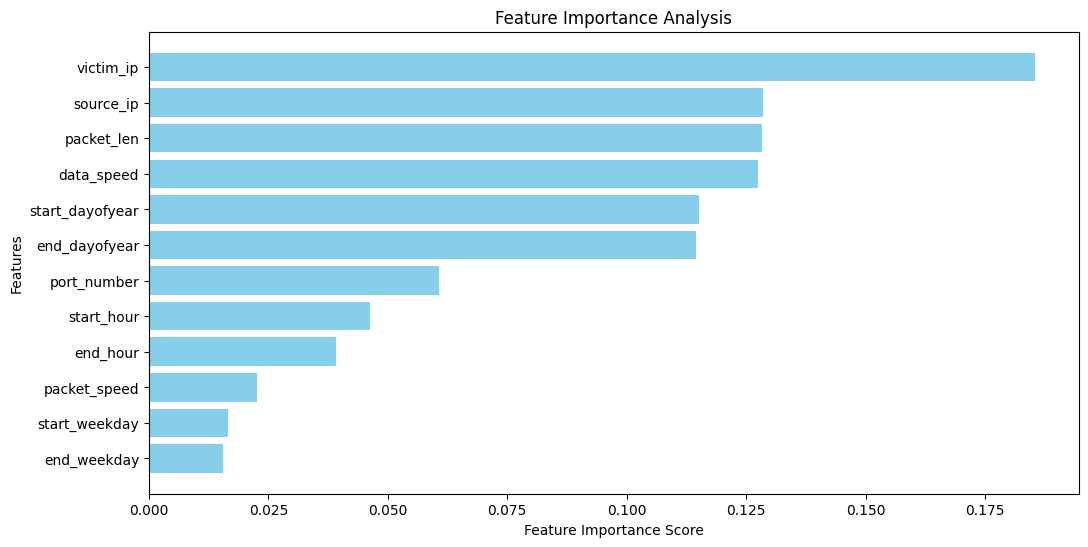

In [ ]:
feature_importance_analysis(resample_data("ROS", 0.25))

# SMOTE

PR AUC for the original dataset: 0.8233
PR AUC for 25% resampled dataset: 0.8630
PR AUC for 50% resampled dataset: 0.9197
PR AUC for 100% resampled dataset: 0.9545


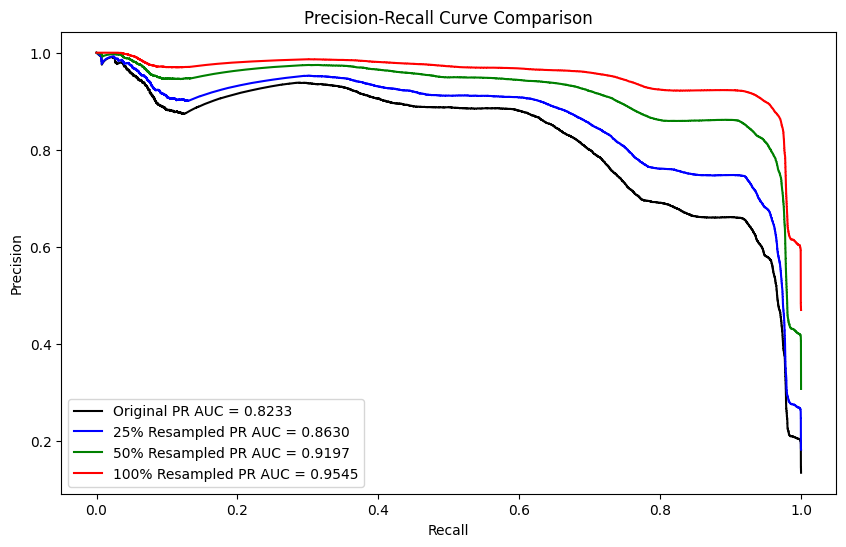

In [ ]:
compare_pr_auc(original_df=df, resampled_dfs={
    25: resample_data("SMOTE", 0.25),
    50: resample_data("SMOTE", 0.5),
    100: resample_data("SMOTE", 1)
})

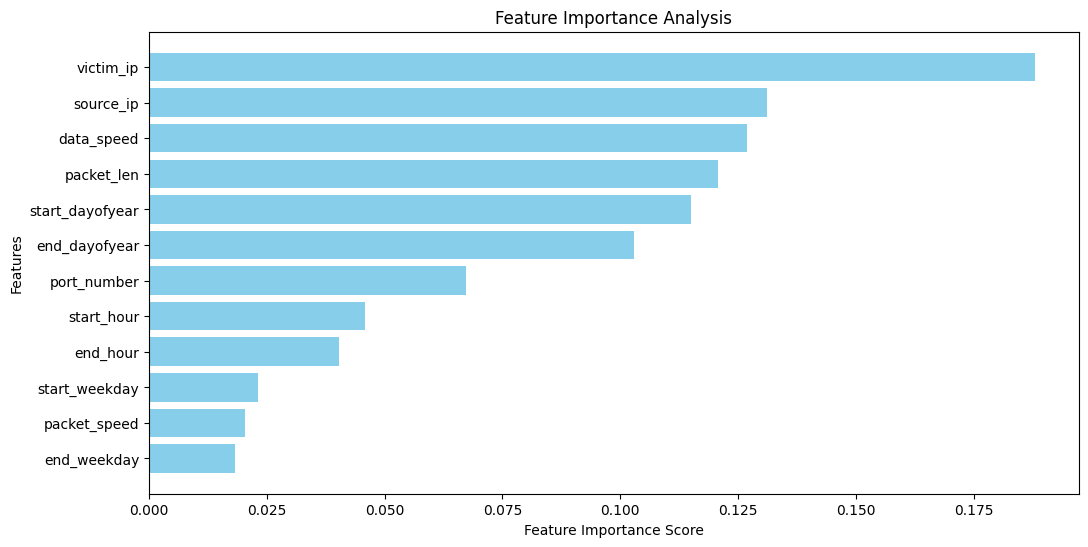

In [ ]:
feature_importance_analysis(resample_data("SMOTE", 0.25))

# ADASYN

PR AUC for the original dataset: 0.8233
PR AUC for 25% resampled dataset: 0.8503
PR AUC for 50% resampled dataset: 0.9084
PR AUC for 100% resampled dataset: 0.9483


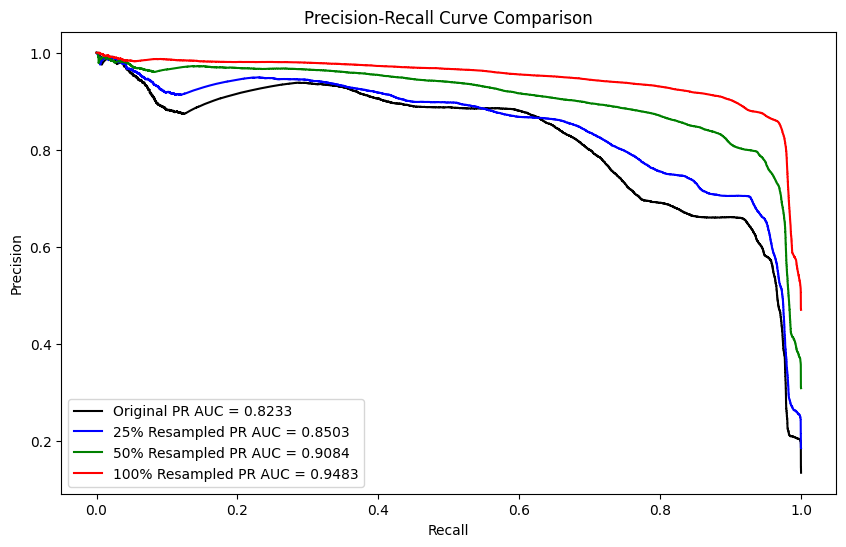

In [ ]:
compare_pr_auc(original_df=df, resampled_dfs={
    25: resample_data("ADASYN", 0.25),
    50: resample_data("ADASYN", 0.5),
    100: resample_data("ADASYN", 1)
})

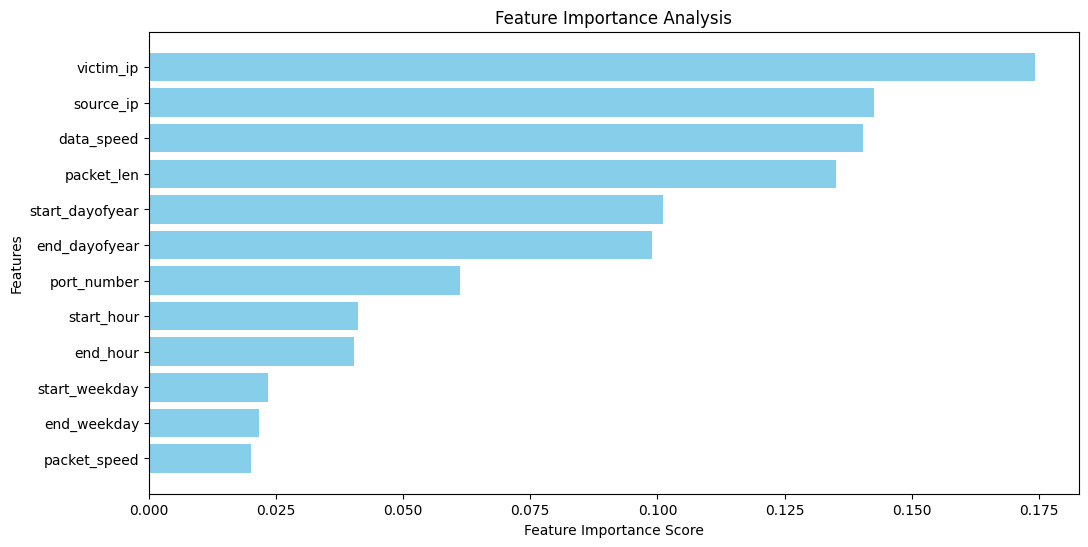

In [ ]:
feature_importance_analysis(resample_data("ADASYN", 0.25))

# BorderlineSMOTE

PR AUC for the original dataset: 0.8233
PR AUC for 25% resampled dataset: 0.8521
PR AUC for 50% resampled dataset: 0.9044
PR AUC for 100% resampled dataset: 0.9445


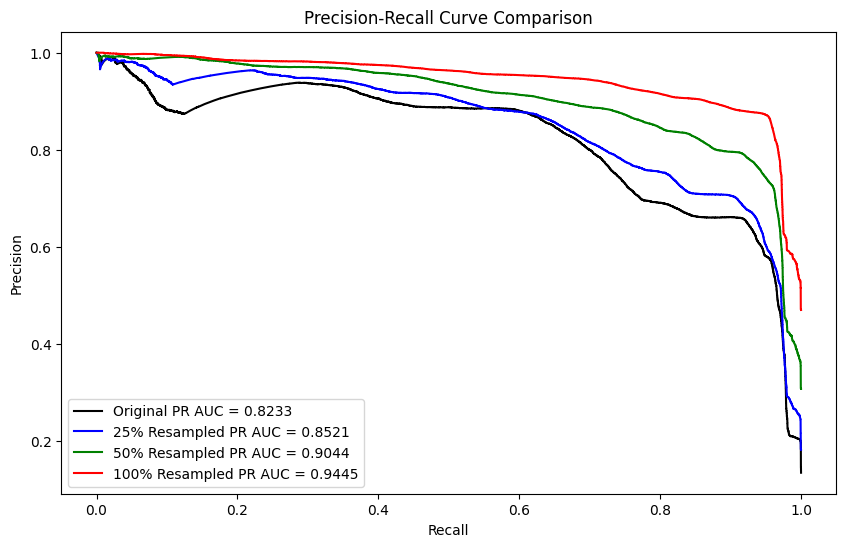

In [ ]:
compare_pr_auc(original_df=df, resampled_dfs={
    25: resample_data("BorderlineSMOTE", 0.25),
    50: resample_data("BorderlineSMOTE", 0.5),
    100: resample_data("BorderlineSMOTE", 1)
})

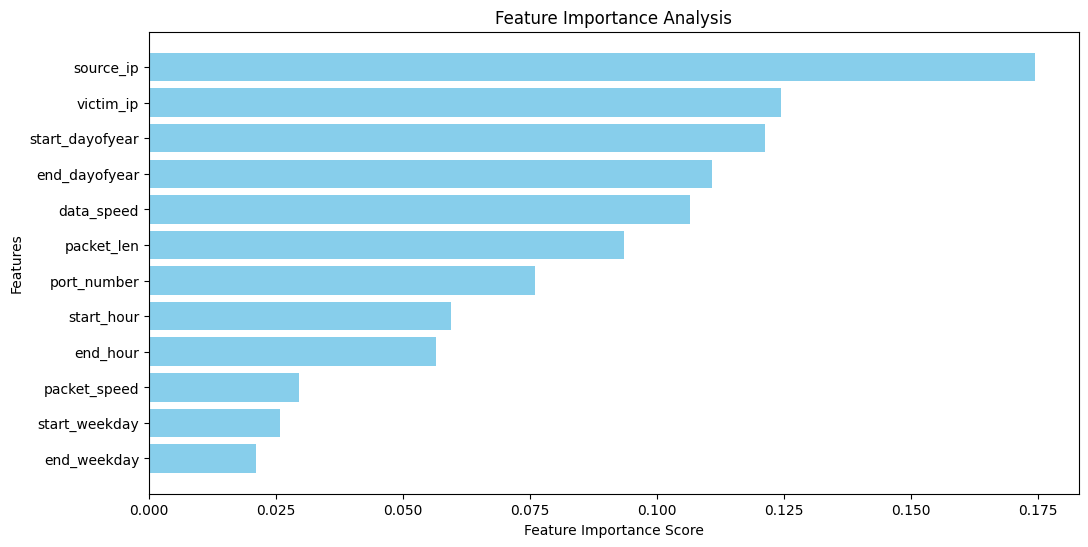

In [ ]:
feature_importance_analysis(resample_data("BorderlineSMOTE", 0.25))

# KMeansSMOTE

PR AUC for the original dataset: 0.8233
PR AUC for 25% resampled dataset: 0.9166
PR AUC for 50% resampled dataset: 0.9757
PR AUC for 100% resampled dataset: 0.9911


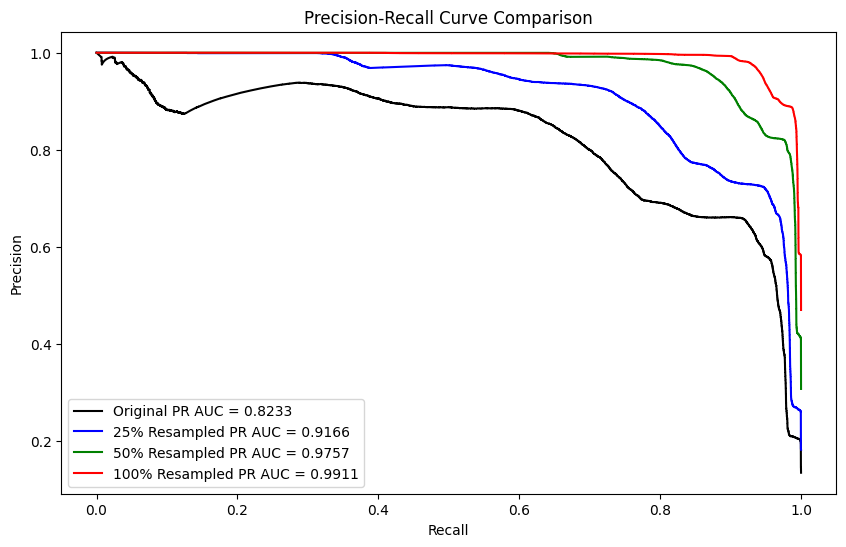

In [ ]:
compare_pr_auc(original_df=df, resampled_dfs={
    25: resample_data("KMeansSMOTE", 0.25),
    50: resample_data("KMeansSMOTE", 0.5),
    100: resample_data("KMeansSMOTE", 1)
})

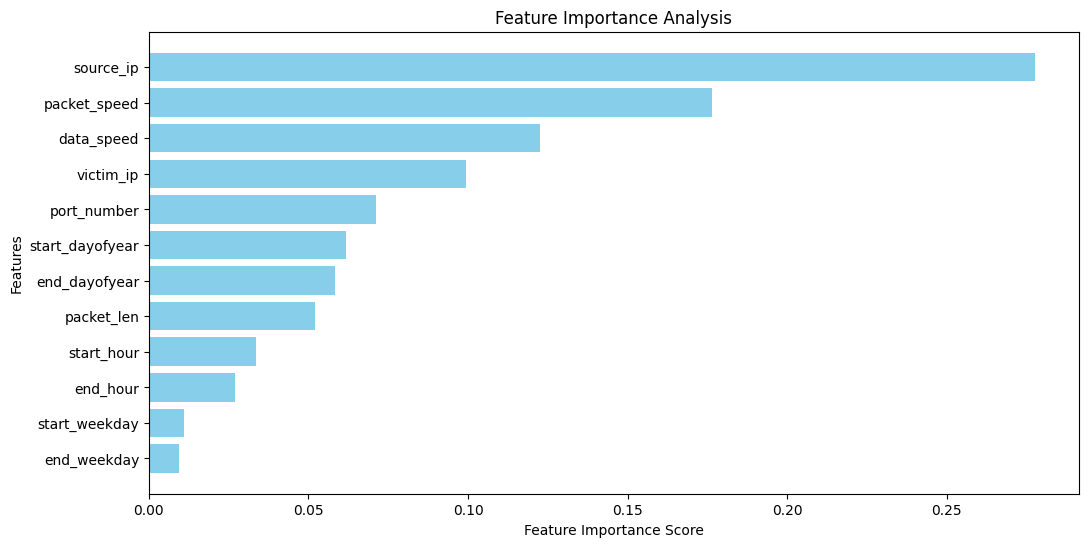

In [ ]:
feature_importance_analysis(resample_data("KMeansSMOTE", 0.25))

# Summary

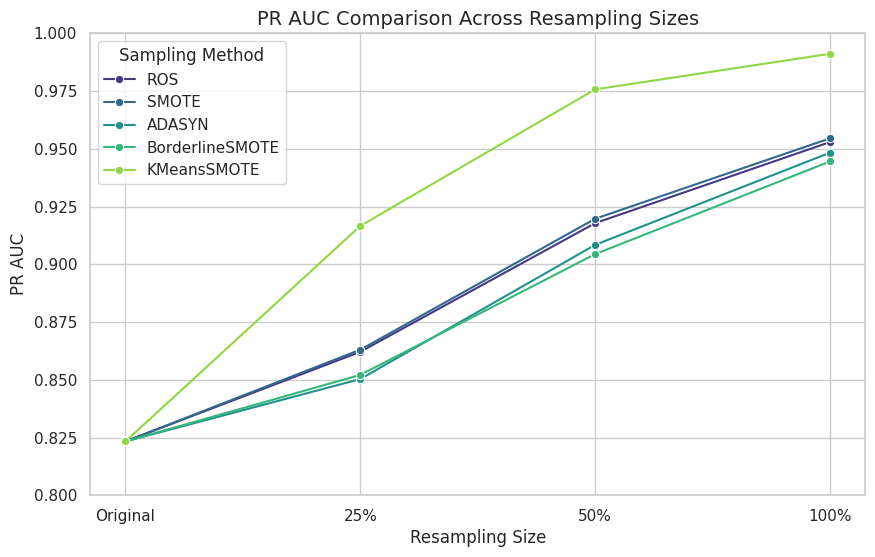

In [ ]:
data = {
    "Resampling Size": ["Original", "25%", "50%", "100%"] * 5,
    "PR AUC": [
        0.8233, 0.8621, 0.9178, 0.9529,  # ROS
        0.8233, 0.8630, 0.9197, 0.9545,  # SMOTE
        0.8233, 0.8503, 0.9084, 0.9483,  # ADASYN
        0.8233, 0.8521, 0.9044, 0.9445,  # BorderlineSMOTE
        0.8233, 0.9166, 0.9757, 0.9911   # KMeansSMOTE
    ],
    "Method": ["ROS"] * 4 + ["SMOTE"] * 4 + ["ADASYN"] * 4 + ["BorderlineSMOTE"] * 4 + ["KMeansSMOTE"] * 4
}

df = pd.DataFrame(data)

sns.set(style="whitegrid")
viridis = sns.color_palette("viridis", as_cmap=True)

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="Resampling Size", y="PR AUC", hue="Method", marker="o", palette="viridis")

plt.title("PR AUC Comparison Across Resampling Sizes", fontsize=14)
plt.xlabel("Resampling Size", fontsize=12)
plt.ylabel("PR AUC", fontsize=12)
plt.ylim(0.8, 1.0)
plt.legend(title="Sampling Method")
plt.show()

# PCA test

In [ ]:
from sklearn.decomposition import PCA

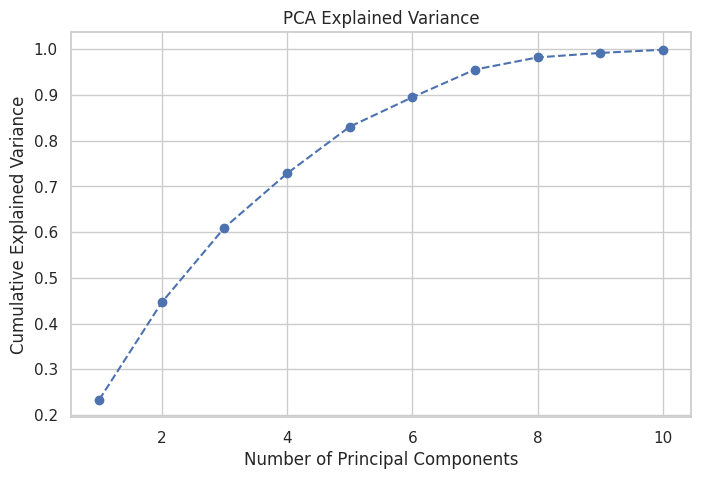

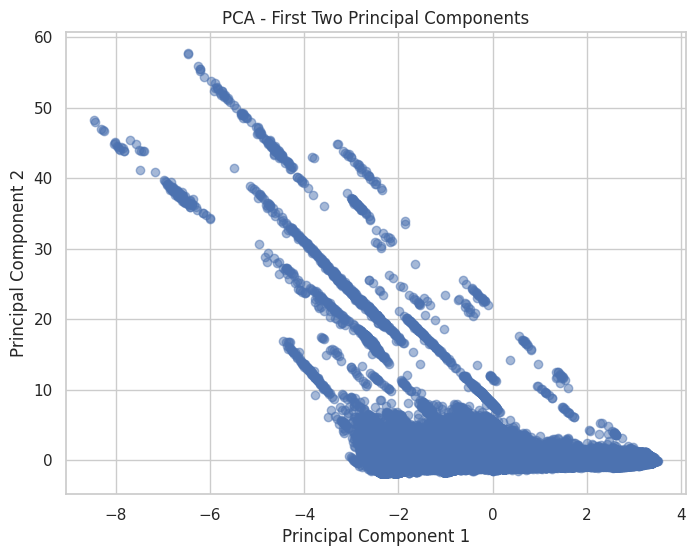

In [ ]:
df_numeric = df.select_dtypes(include=[np.number])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric)

pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA - First Two Principal Components")
plt.show()